In [7]:
%load_ext autoreload
%autoreload 2
from methods2final import * 

sc.settings.verbosity = 3  
sc.logging.print_versions()
results_file = '../dat/write/pfc2018.h5ad'
sc.settings.set_figure_params(dpi=160)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.4.1 anndata==0.6.19 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 


## Data preprocessing

In [8]:
# Transepose the expression matrix to gene as rows and cells as columns
df = pd.read_csv("../dat/GSE104276_all_pfc_2394_UMI_TPM_NOERCC.csv")
exp_mat = df.transpose()
exp_mat.to_csv("../dat/GSE104276_all_pfc_2394_UMI_TPM_NOERCC_exp_mat.csv")

In [9]:
exp_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,24143,24144,24145,24146,24147,24148,24149,24150,24151,24152
GENE,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
GW08_PFC1_sc1,4.54,0,0,4.54,0,0,0,0,4.54,0,...,4.54,4.54,0,0,45.4,0,4.54,0,0,0
GW08_PFC1_sc2,0,0,0,0,0,0,0,0,0,0,...,0,81.19,0,0,0,0,108.25,0,0,0
GW08_PFC1_sc3,0,0,0,8.87,0,0,0,0,0,0,...,124.25,0,0,0,0,0,8.87,124.25,0,35.5
GW08_PFC1_sc4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,189.05,0,0,0,0,0,0


In [11]:
adata = sc.read_csv('../dat/GSE104276_all_pfc_2394_UMI_TPM_NOERCC_exp_mat.csv', delimiter=',')
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 2 cells that have less than 1 counts


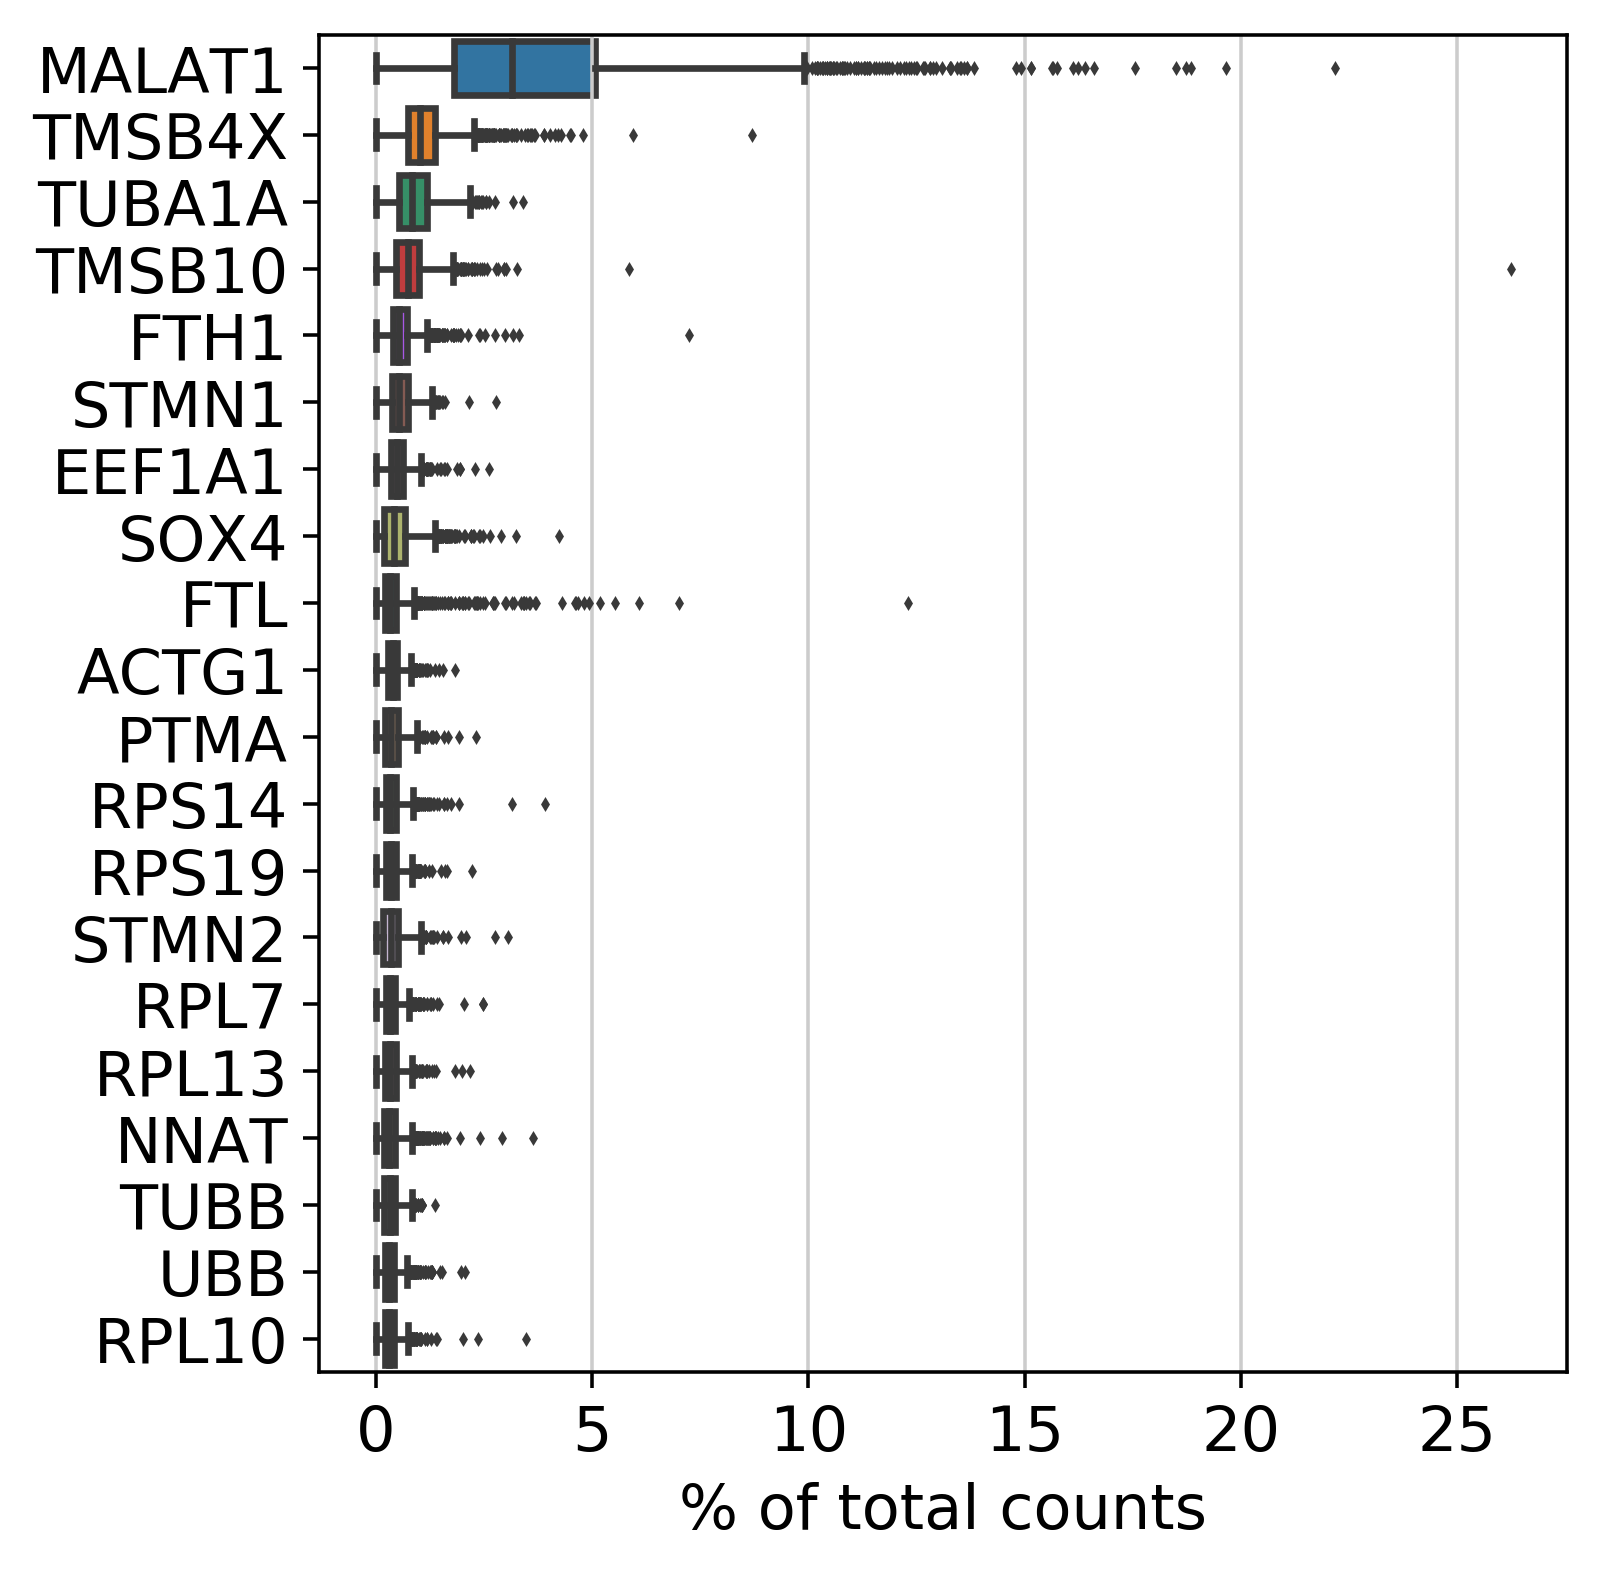

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16 cells that have less than 200 genes expressed
filtered out 3887 genes that are detected in less than 3 cells


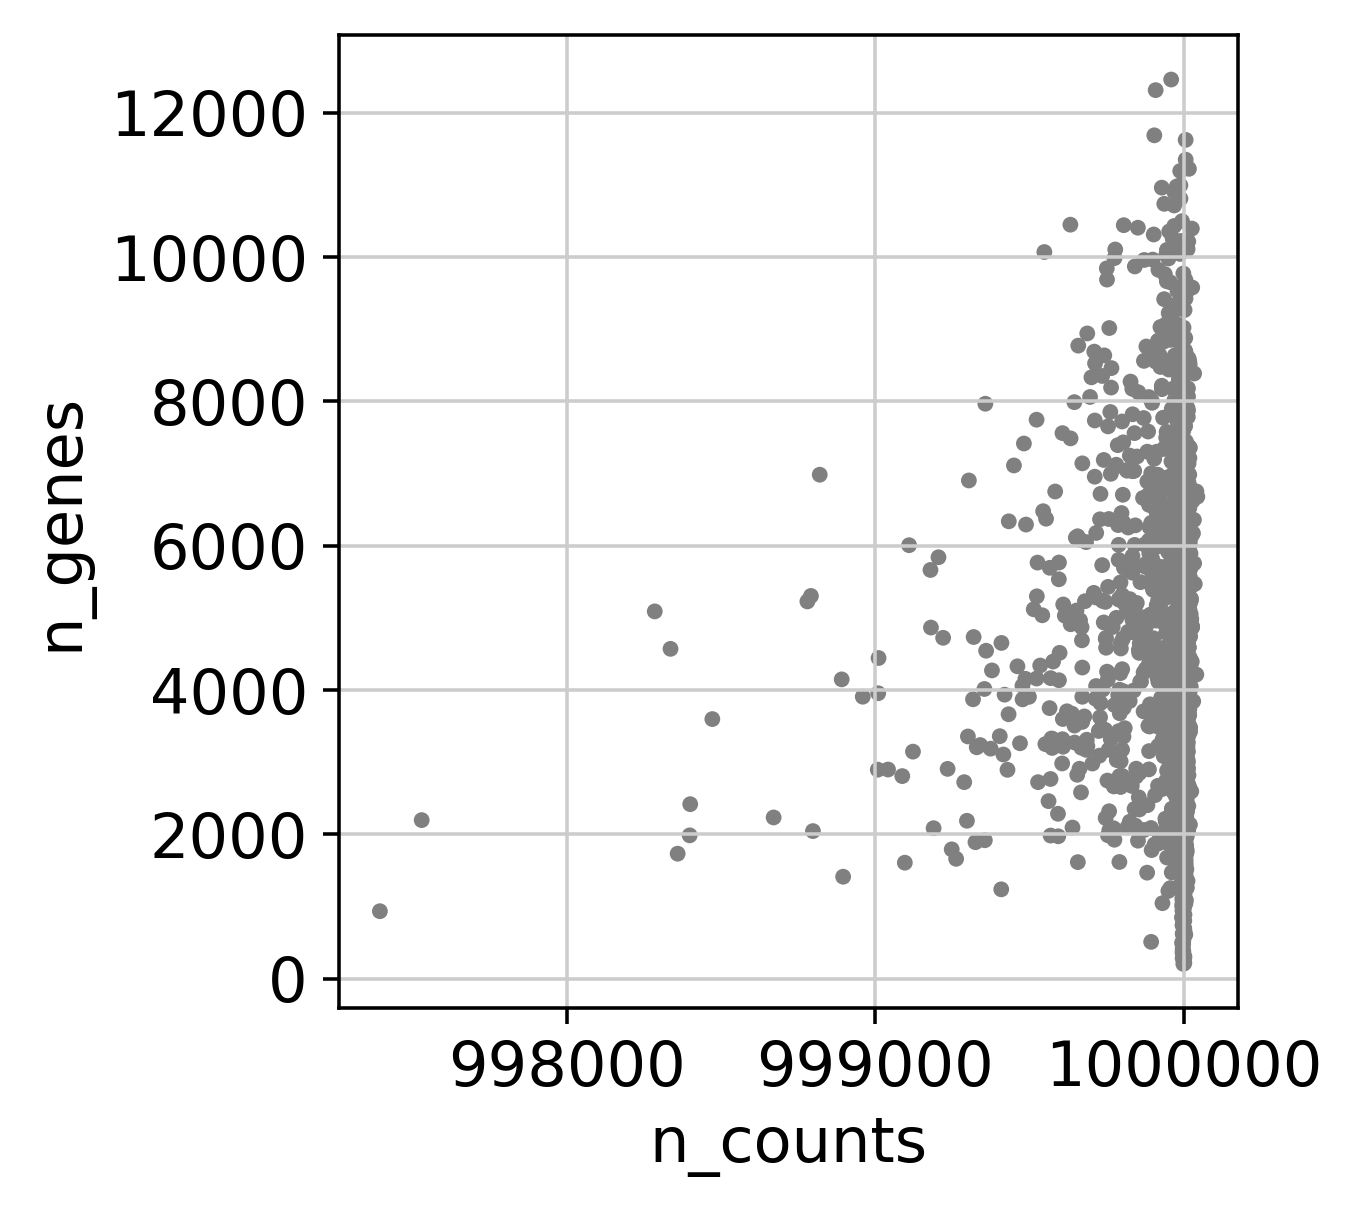

In [14]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [16]:
adata.raw = adata

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


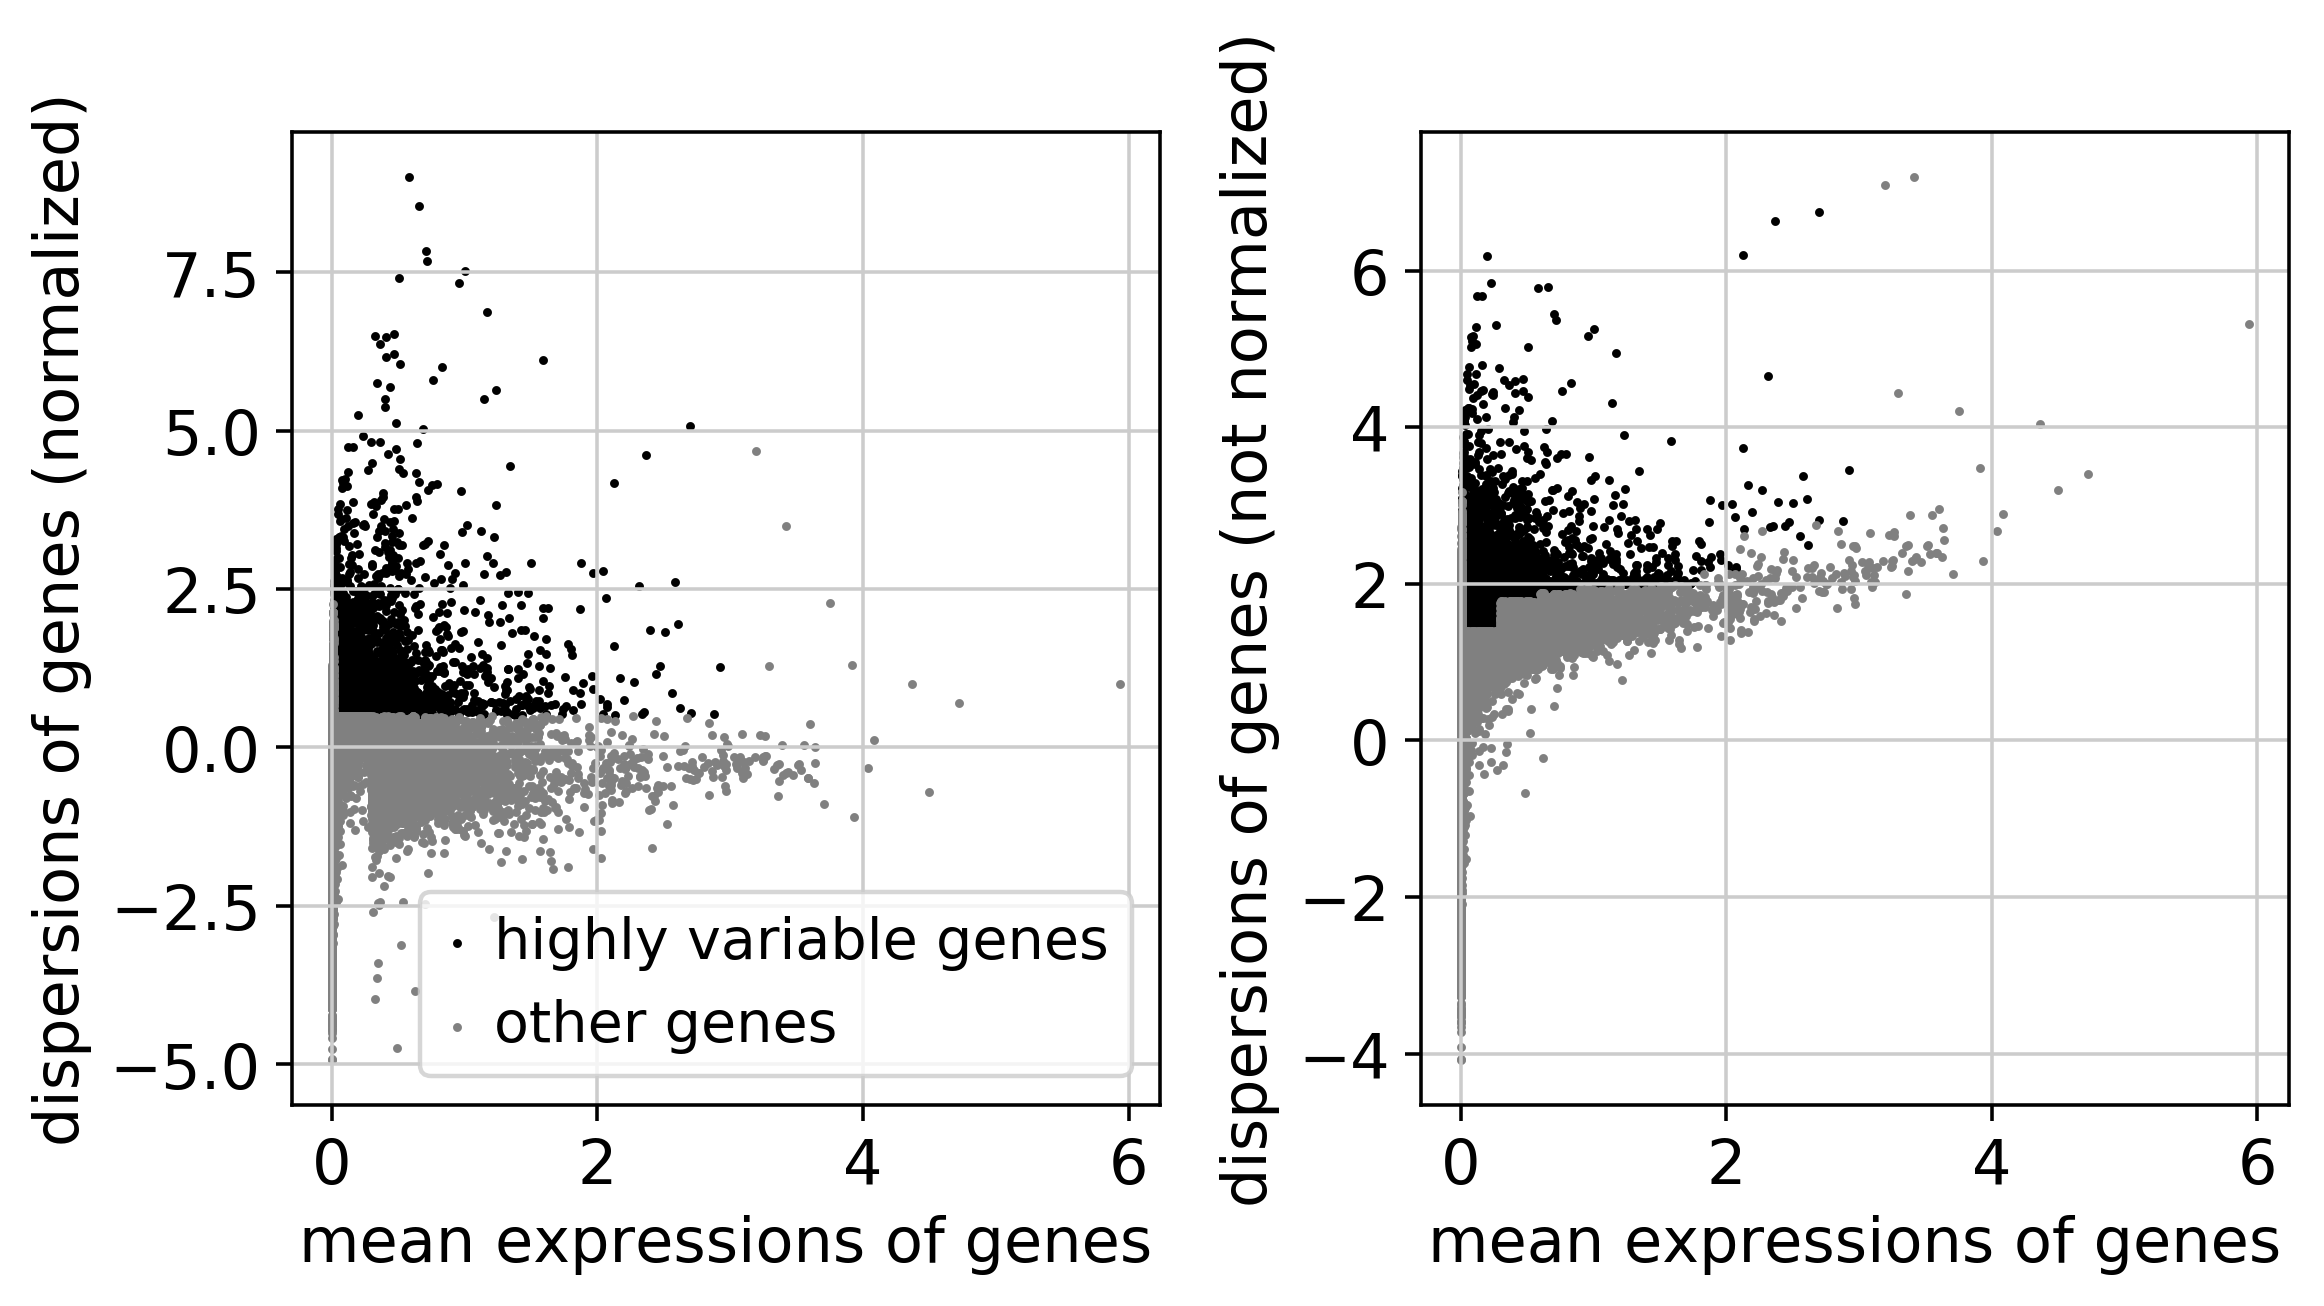

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata = adata[:, adata.var['highly_variable']]

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA on highly variable genes


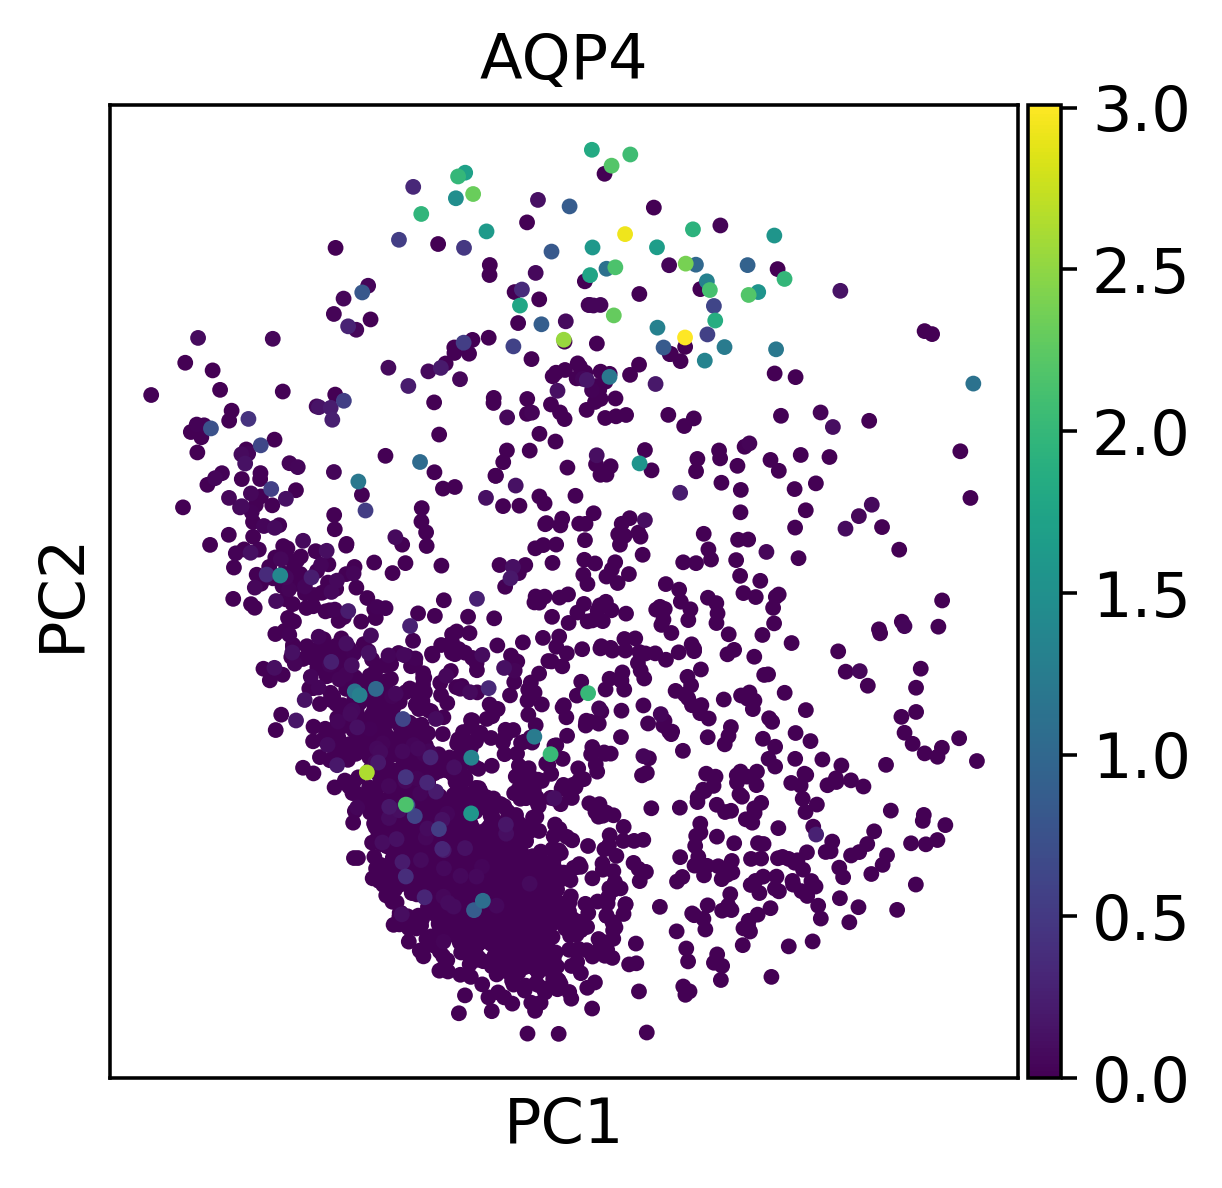

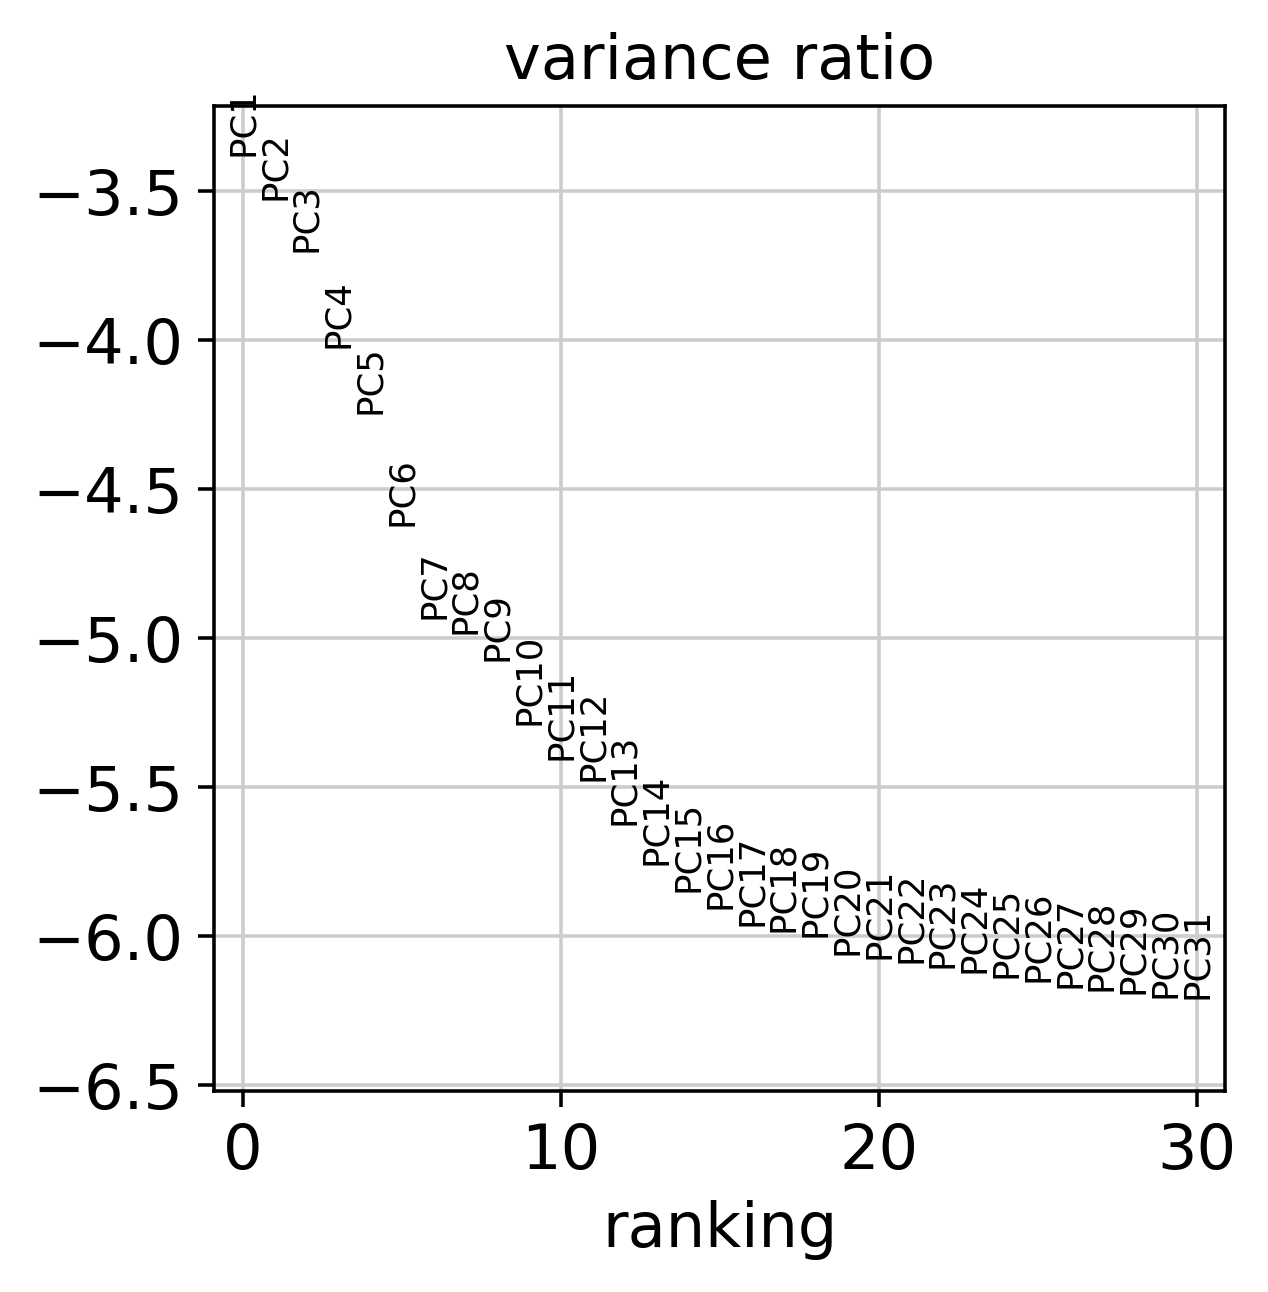

In [21]:
sc.pl.pca(adata, color='AQP4')
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
adata.write(results_file)

In [24]:
adata

AnnData object with n_obs × n_vars = 2378 × 4490 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [25]:
adata.obs.index

Index(['GW08_PFC1_sc1', 'GW08_PFC1_sc2', 'GW08_PFC1_sc3', 'GW08_PFC1_sc4',
       'GW08_PFC1_sc5', 'GW08_PFC1_sc6', 'GW08_PFC1_sc7', 'GW08_PFC1_sc8',
       'GW08_PFC1_sc9', 'GW08_PFC1_sc11',
       ...
       'GW23_PFC2_SF2_F25_sc41', 'GW23_PFC2_SF2_F25_sc42',
       'GW23_PFC2_SF2_F25_sc43', 'GW23_PFC2_SF2_F25_sc44',
       'GW23_PFC2_SF2_F25_sc45', 'GW23_PFC2_SF2_F25_sc46',
       'GW23_PFC2_SF2_F25_sc47', 'GW23_PFC2_SF2_F25_sc48',
       'GW23_PFC2_SF2_F25_sc49', 'GW23_PFC2_SF2_F25_sc50'],
      dtype='object', length=2378)

In [26]:
adata.obs["ID"] = adata.obs.index
adata.obs["week"] = adata.obs.apply(lambda row:row["ID"].split("_")[0], axis=1)

In [37]:
sc.tl.tsne(adata, use_rep='X', n_pcs=20)

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:30.79) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


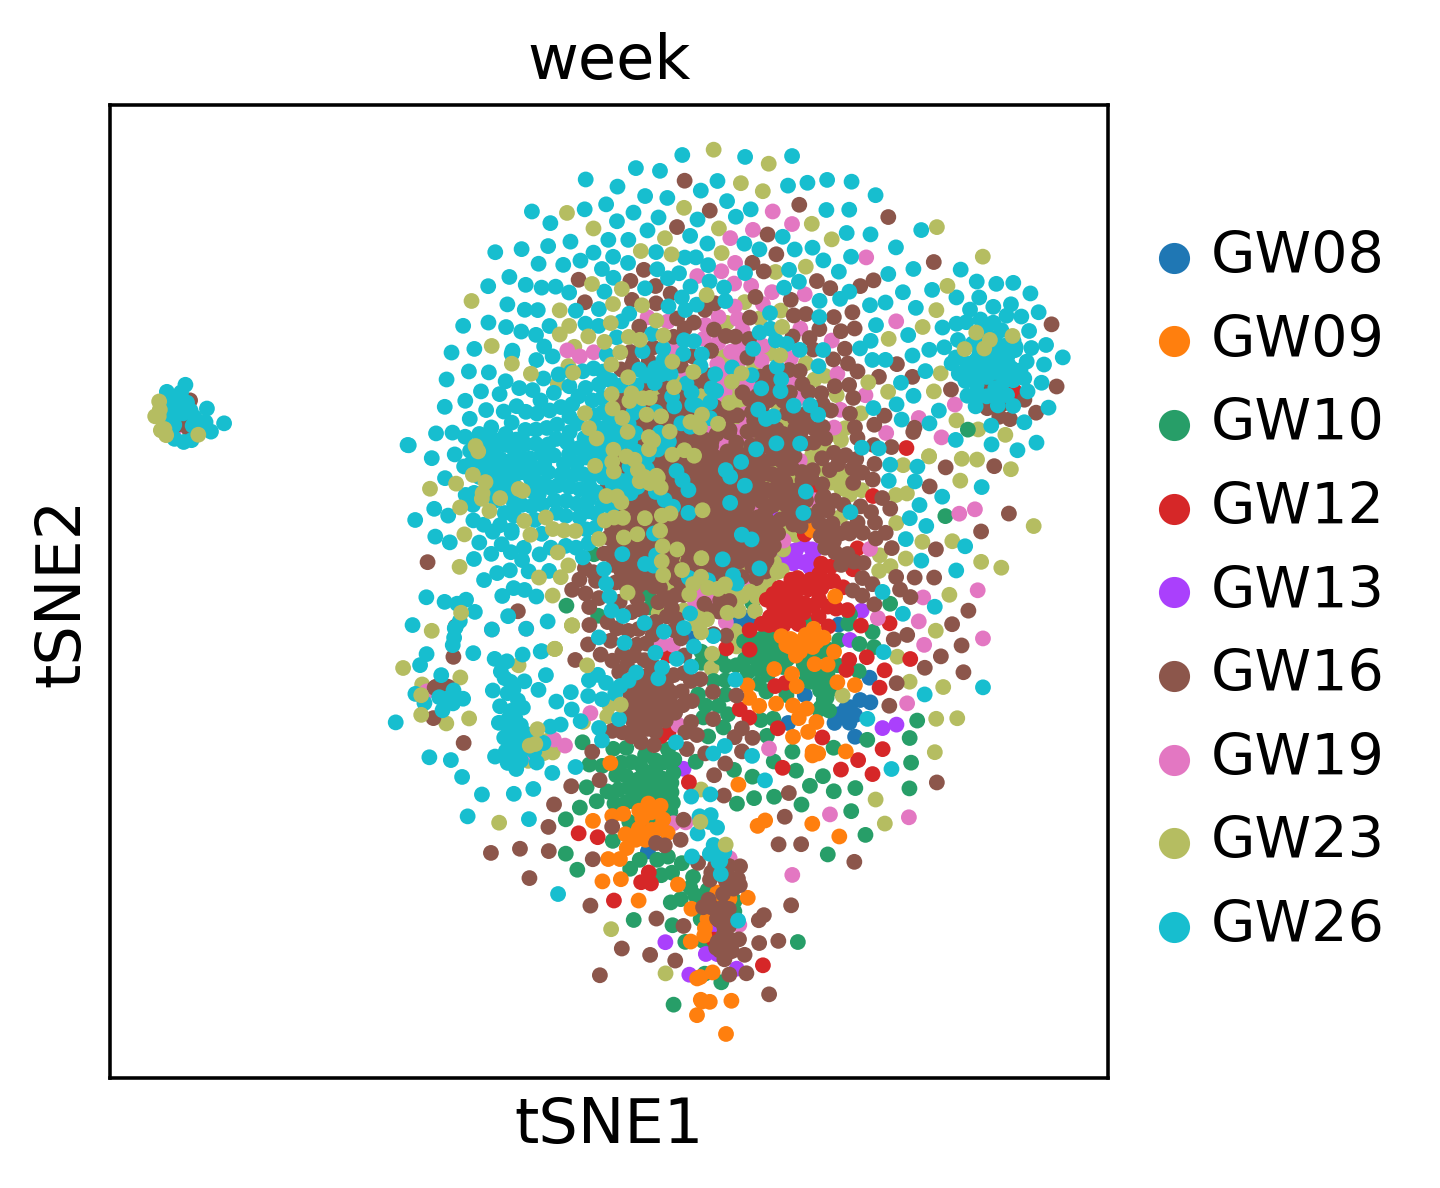

In [38]:
sc.pl.tsne(adata, color='week')

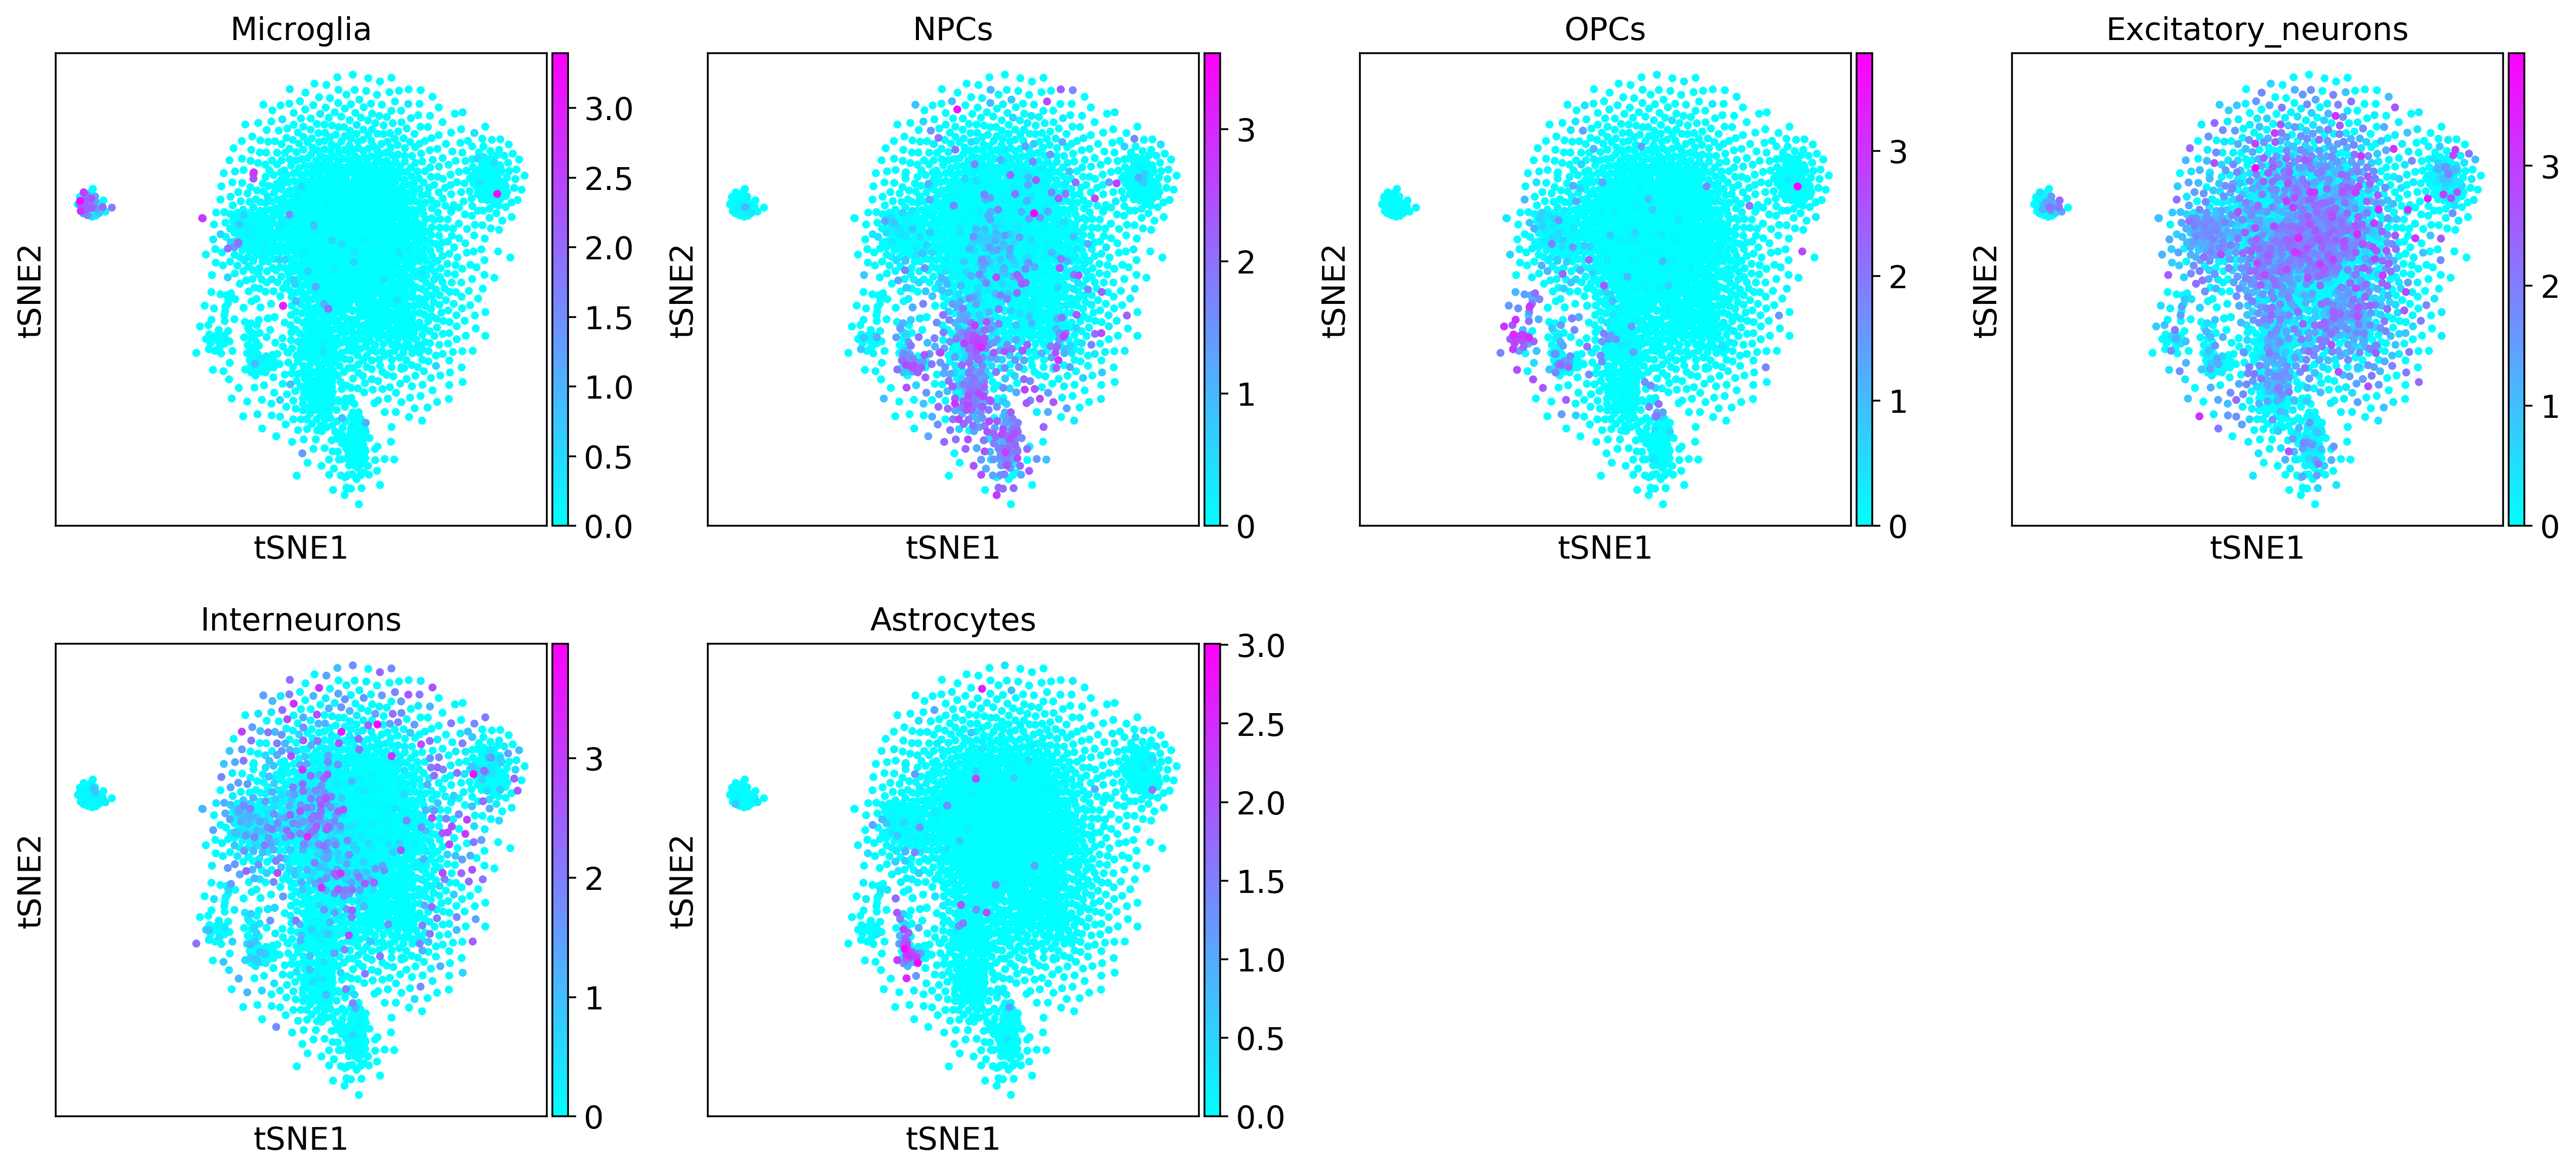

In [39]:
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

In [29]:
adata.var["gene"] = adata.var.index

In [30]:
adata.var[adata.var["gene"]=="PTPRC"]

,n_cells,highly_variable,means,dispersions,dispersions_norm,gene
PTPRC,228,True,0.14319,2.256677,1.353098,PTPRC


In [31]:
type(adata.X)

numpy.ndarray

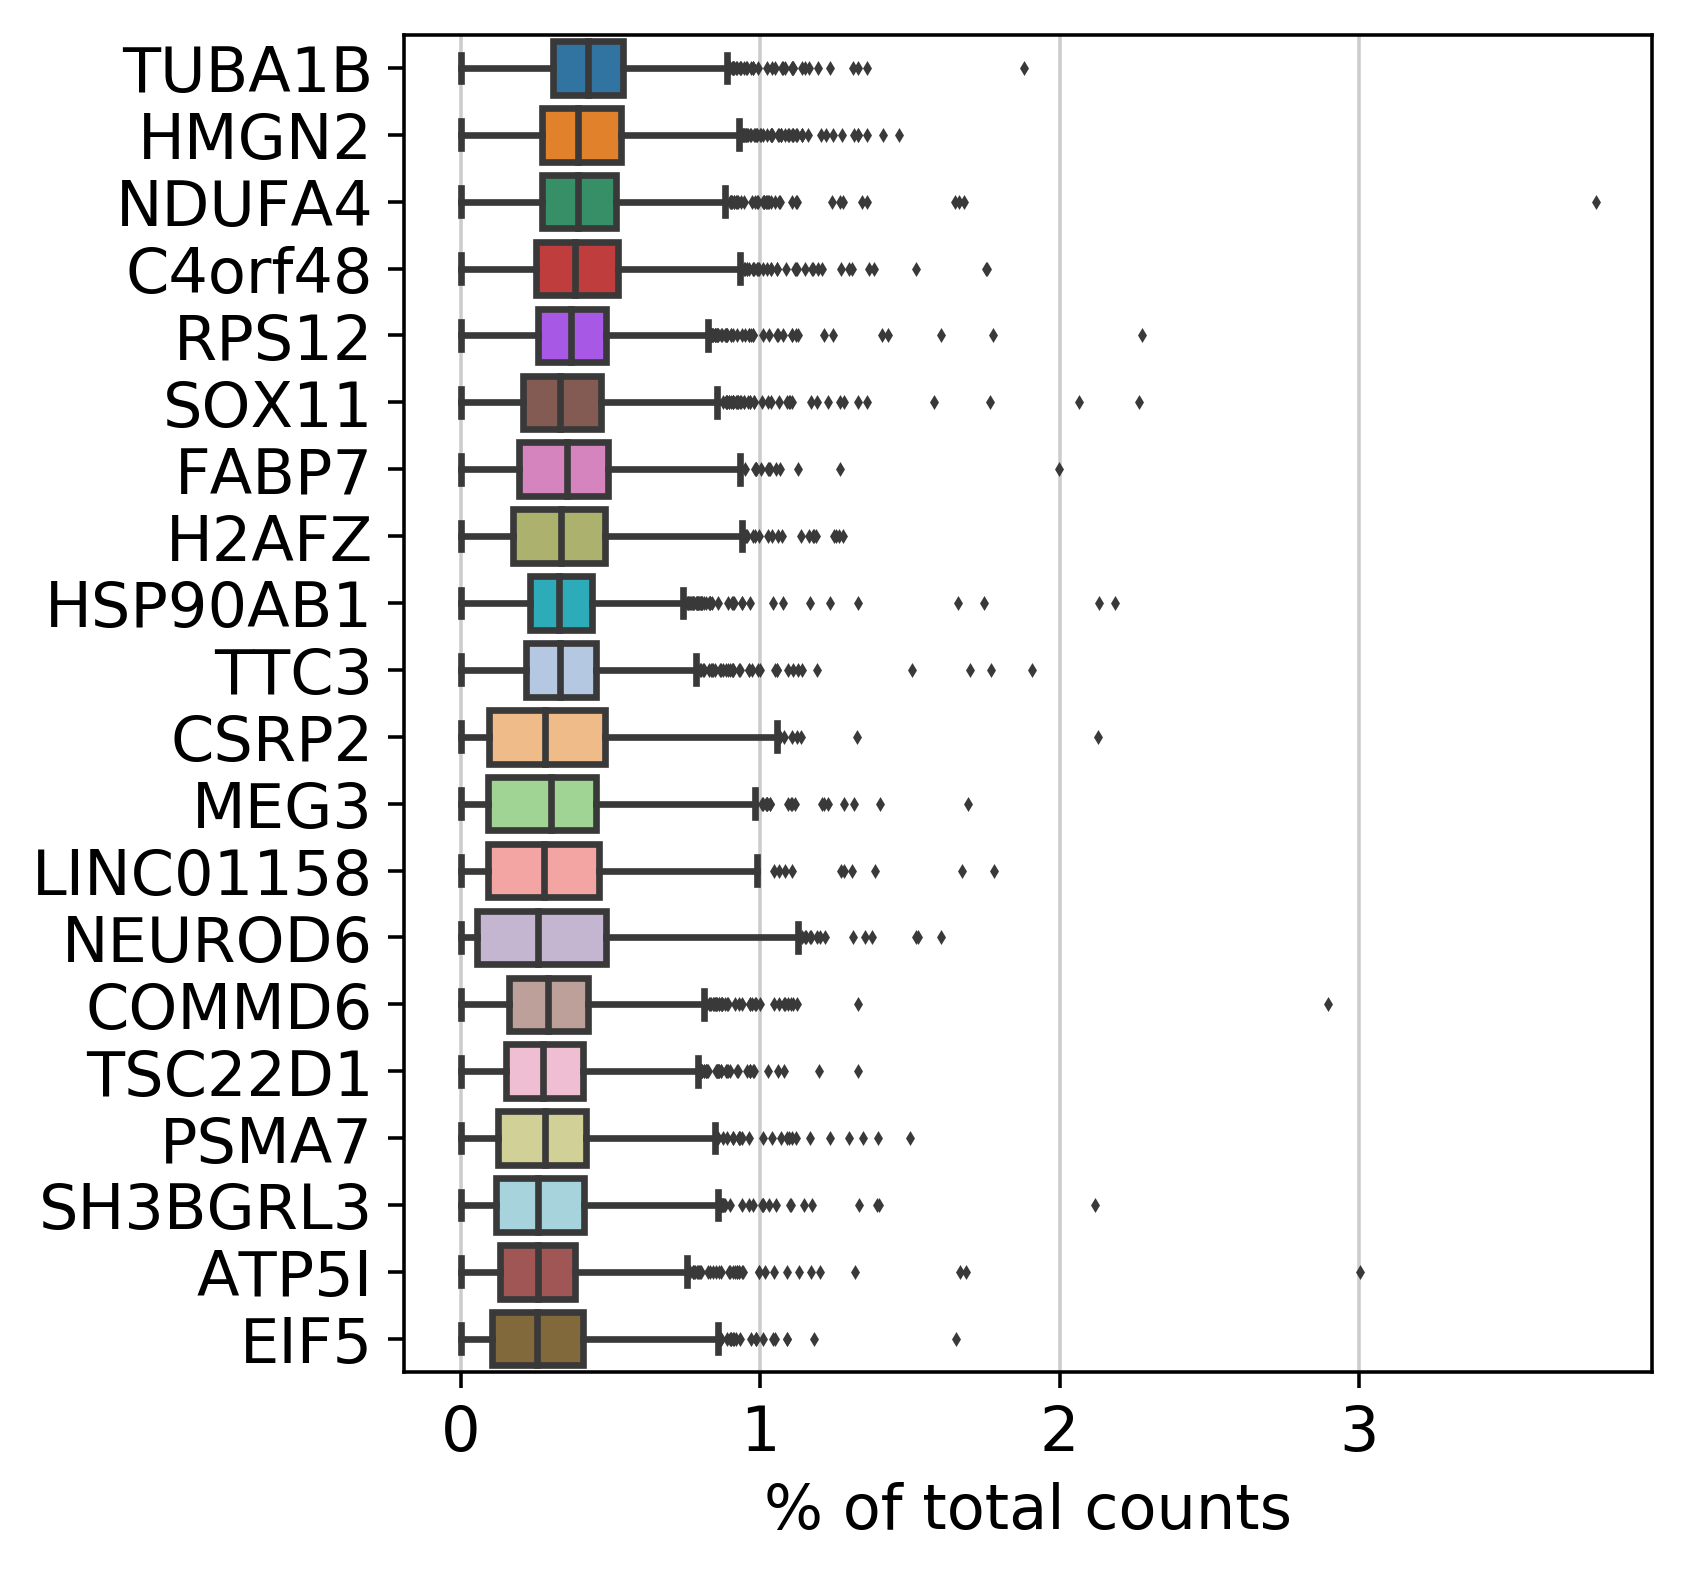

In [32]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [33]:
adata.write(results_file)